<a href="https://colab.research.google.com/github/sasidharswarangi/Modified-DFS-based-term-weighting/blob/main/Modified_DFS_based_term_weighting_scheme_for_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified DFS-based term weighting scheme for text classification

## Abstract

With the rapid growth of textual data on the Internet, text classification (TC) has attracted increasing attention. As a widely used text representation method, the vector space model (VSM) represents the content of a document as a vector commposed of term frequeny (TF) in the term space. Because different terms have different levels of importance in a document, designing an appropriate term weighting scheme is crucial to improve performance of TC. In this study, we first conducted a comprehensive survey of the existing well-known term weighting schemes and found that they are not fully effective and that researchers are still focused on proposing new term weighting schemes. To further improve the performance of TC, we propose a new term weighting scheme based on the modified distinguishing feature selector (DFS), which we call TF-MDFS (modified DFS-based TF). Experimental results show that TF-MDFS is overall better than existing state-of-the-art term weighting schmes in terms of the classification accuracy of widely used base classifier.

- Submitted by Abhishek Kumar (181CO201), Swarangi Sasidhar (181CO245)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def drive_path(file_name):
  return '/content/drive/MyDrive/Modified DFS-based term weighting scheme for text classification/' + file_name

## Pre-process Data

1. Tokenization: Tokenization breaks down the stream of text into words, phrases and other meaningful elements called tokens. For example: the string `'Today will be a good day!'` is broken into tokens `['Today', 'will', 'be', 'a', 'good', 'day']`.

2. Word Stemming: Stemming is the process of reducing inflected words to their word stem, a base or root form of the word.

3. Lemmatization: Similar to stemming, lemmization also aims to reduce inflected word to their base form. However, lemmatization uses the context of the word as well as vocabulary rules to reduce the word whereas stemming operates on the word itself. Thus, stemming is easier to implement and faster but less accurate than lemmization.

| Word | Stemming | Lemmatization |
| ---- | -------- | ------------- |
| Studying | Study | Study |
| Studies  | Studi | Study |

4. Removing Stop Words: Stop words are very common words like `'and'`, `'the'` and `'him'`. As such words will have high frequency (appearing in nearly every document) but are uninformative, we drop them from our list of tokens.

In [ ]:
import nltk

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from collections import defaultdict

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder

lemma_mapping = defaultdict(lambda: wordnet.NOUN)
lemma_mapping['J'] = wordnet.ADJ
lemma_mapping['V'] = wordnet.VERB
lemma_mapping['R'] = wordnet.ADV

word_lemmatizer = WordNetLemmatizer()
english_stopwords = stopwords.words('english')

def pre_process(entry):
  #  Convert all text to lower case
  entry = entry.lower()

  # Tokenize words
  words = word_tokenize(entry)

  # Remove words with non-alpabetic characters 
  words = list(filter(lambda word: word.isalpha(), words))

  # Remove words in the stopword-list
  # TODO: See if this step can be made faster
  words = list(filter(lambda word: word not in english_stopwords, words))

  # Lemmatize words into a standard form
  standardized_words = [word_lemmatizer.lemmatize(word, lemma_mapping[tag[0]]) for word, tag in pos_tag(words)]

  return ' '.join(standardized_words)

## Load Datasets

In [ ]:
# Read the pickled dataframe or initialize empty dictionary

import pickle

datasets = {}

import os

if os.path.exists(drive_path('datasets.pkl')):
  with open(drive_path('datasets.pkl'), 'rb') as f:
    datasets = pickle.load(f)

### Amazon Review Dataset

Source: https://raw.githubusercontent.com/Gunjitbedi/Text-Classification/master/corpus.csv

In [ ]:
# Import Amazon Reviews

if 'amazon_reviews' not in datasets:
  amazon_reviews = pd.read_csv(drive_path('amazon_reviews.csv'))
  amazon_reviews['text'].dropna(inplace=True)

  datasets['amazon_reviews'] = {
      'processed_text': amazon_reviews['text'].apply(lambda row: pre_process(row)),
      'processed_label': LabelEncoder().fit_transform(amazon_reviews['label']),
      'formal_name': 'Amazon Review Dataset'
  }

print(datasets['amazon_reviews']['processed_text'][:5])
print(datasets['amazon_reviews']['processed_label'][:5])

0    stun even sound track beautiful paint senery m...
1    best soundtrack ever anything reading lot revi...
2    amaze soundtrack favorite music time hand inte...
3    excellent soundtrack truly like soundtrack enj...
4    remember pull jaw floor hear played game know ...
Name: text, dtype: object
[1 1 1 1 1]


### Polarity v2.0 Movie Review Dataset

The Polarity v2.0 Moview Review Dataset contains 1000 positive and 1000 negative movie reviews taken from IMbD archive of [rec.arts.movies.reviews.newgroup](http://reviews.imdb.com/Reviews).

Source: https://www.kaggle.com/anindya2906/movie-review-polarity

In [ ]:
# Import Movie Reviews

if 'movie_reviews' not in datasets:
  movie_reviews = pd.read_csv(drive_path('movie_reviews.csv'))

  movie_reviews['text'].dropna(inplace=True)

  datasets['movie_reviews'] = {
      'processed_text': movie_reviews['text'].apply(lambda row: pre_process(row)),
      'processed_label': LabelEncoder().fit_transform(movie_reviews['label']),
      'formal_name': 'Polarity v2.0 Movie Review Dataset'
  }

print(datasets['movie_reviews']['processed_text'][:5])
print(datasets['movie_reviews']['processed_label'][:5])

0    watch first ten minute japanese film never eat...
1    scary movie anyhow movie person get rip shred ...
2    time reason baby sitter recently go multiplex ...
3    attempt florida film noir palmetto fail fundam...
4    review visit clear illusion www clearillusions...
Name: text, dtype: object
[1 1 0 0 1]


### RSS Feed Topics Dataset

The RSS Feed Topics Dataset has 5974 articles with their title and content, classified into eight different categories like entertainments, news and others.

Source: https://www.kaggle.com/brobear1995/rss-feed-topic-classifier

In [ ]:
# Import RSS Topics

if 'rss_topics' not in datasets:
  rss_topics = pd.read_csv(drive_path('rss_topics.csv'))

  rss_topics['title'].dropna(inplace=True)

  datasets['rss_topics'] = {
      'processed_text': rss_topics['title'].apply(lambda row: pre_process(row)),
      'processed_label': LabelEncoder().fit_transform(rss_topics['Topic']),
      'formal_name': 'RSS Feed Topics Dataset'
  }

print(datasets['rss_topics']['processed_text'][:5])
print(datasets['rss_topics']['processed_label'][:5])

0    ad password policy compare nist password recom...
1    hacker use fake trump scandal video spread qno...
2    russian hacker get prison massive jp morgan ch...
3    google api help attacker easily bypass google ...
4    secret backdoor account find several zyxel fir...
Name: title, dtype: object
[3 3 3 3 3]


In [ ]:
# Pickle back the processed datasets into a file

import pickle

with open(drive_path('datasets.pkl'), 'wb') as f:
  pickle.dump(datasets, f)

## Train Models

Similar to the paper, we will be using Naive-Bayes Classifier, Support Vector Machines and Logistic Regression to classify the documents.

In [ ]:
# Train Naive-Bayes Classifier

from sklearn import naive_bayes

def train_naive_bayes(x_train, y_train, x_test, y_test):
  classifier = naive_bayes.MultinomialNB()
  classifier.fit(x_train, y_train)
  
  return classifier.predict(x_test)

In [ ]:
# Train SVM

from sklearn.svm import SVC

def train_svm(x_train, y_train, x_test, y_test):
  classifier = SVC()
  classifier.fit(x_train, y_train)
  
  return classifier.predict(x_test)

In [ ]:
# Train Logistic Regression

from sklearn.linear_model import LogisticRegression

def train_logistic_regression(x_train, y_train, x_test, y_test):
  classifier = LogisticRegression()
  classifier.fit(x_train, y_train)

  return classifier.predict(x_test)

In [ ]:
# Helper function which calls the specific ML models

from sklearn.metrics import accuracy_score

def train_models(x_train, y_train, x_test, y_test):
  naive_bayes_predictions = train_naive_bayes(x_train, y_train, x_test, y_test)
  svm_predictions = train_svm(x_train, y_train, x_test, y_test)
  logistic_regression_predictions = train_logistic_regression(x_train, y_train, x_test, y_test)

  return (
      100 * accuracy_score(naive_bayes_predictions, y_test),
      100 * accuracy_score(svm_predictions, y_test),
      100 * accuracy_score(logistic_regression_predictions, y_test)
  )

## Calculate Weights for Vector Space Model

ML Models cannot operate directly on the textual data of the documents. They are represented as **Vector Space Model**, that is a vector of identifiers and the models operate on the vectors as usual.

The documents are transformed into vectors through a **term-weighting scheme** and since the term weighting scheme encodes all textual information about document, designing an appropriate term-weighting scheme is crucial.


In [ ]:
# Split data into training and testing
from sklearn.model_selection import train_test_split

for name, dataset in datasets.items():
  X_train, X_test, Y_train, Y_test = train_test_split(
      dataset['processed_text'], 
      dataset['processed_label'], 
      test_size=0.2, 
      random_state=42
  )
  
  datasets[name]['X_train'] = X_train
  datasets[name]['X_test']  = X_test
  
  datasets[name]['Y_train'] = Y_train
  datasets[name]['Y_test']  = Y_test

### Term Frequency

The simplest term-weighting scheme is **Term Frequency**. It selects the most frequently occuring terms and for each document, notes the number of times the term appears in the document.

Formally,

$$tf(t, d) = f(t, d)$$


In [ ]:
# Build Count Vector

from sklearn.feature_extraction.text import CountVectorizer

for name, dataset in datasets.items():
  count_vectorizer = CountVectorizer(max_features=1000)  
  count_vectorizer.fit(datasets[name]['X_train'])

  datasets[name]['X_train_counts'] = count_vectorizer.transform(dataset['X_train'])
  datasets[name]['X_test_counts'] = count_vectorizer.transform(dataset['X_test'])

  bigram_vectorizer = CountVectorizer(max_features=5000,
                                      ngram_range=(1, 2),
                                      token_pattern=r'\b\w+\b',
                                      min_df=1)

  bigram_vectorizer.fit(datasets[name]['X_train'])
  datasets[name]['X_train_bigram_counts'] = bigram_vectorizer.transform(dataset['X_train'])
  datasets[name]['X_test_bigram_counts'] = bigram_vectorizer.transform(dataset['X_test'])

In [ ]:
# Use TF as the metric

from sklearn.metrics import accuracy_score

tf_accuracies = {}
bigram_tf_accuracies = {}

for name, dataset in datasets.items():
  tf_accuracies[name] = train_models(
      dataset['X_train_counts'],
      dataset['Y_train'],
      dataset['X_test_counts'],
      dataset['Y_test']
  )

  bigram_tf_accuracies[name] = train_models(
      dataset['X_train_bigram_counts'],
      dataset['Y_train'],
      dataset['X_test_bigram_counts'],
      dataset['Y_test']
  )

print('Term Frequency')
print(tf_accuracies)
print(bigram_tf_accuracies)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Term Frequency
{'amazon_reviews': (80.5, 82.19999999999999, 82.65), 'movie_reviews': (79.25, 80.25, 80.0), 'rss_topics': (65.53191489361701, 61.361702127659576, 67.14893617021276)}
{'amazon_reviews': (83.1, 83.85000000000001, 83.55), 'movie_reviews': (79.5, 80.75, 84.75), 'rss_topics': (68.08510638297872, 61.361702127659576, 67.74468085106383)}


### Term Frequency Inverse Document Frequency

In a large corpus, certain words like "the", "is" have limited discriminating power because they appear frequently and in most documents. In constrast, a term that appears frequently but rarely (that is, in concentrated manner) should have greater weights.

**Term Frequency Inverse Document Frequency** models the above intuition with the following equation:

$$tf-idf(t, d) = tf(t, d) \times idf(t)$$

$$idf(t) = 1 + log\frac{1 + n}{1 + df(t)}$$

where $tf(t, d)$ is the term frequency, $df(t)$ is the number of documents that contain the term $t$ and $n$ is the total number of documents.

In [ ]:
# Use TF-IDF as the metric

from sklearn.feature_extraction.text import TfidfTransformer

tf_idf_accuracies = {}
bigram_tf_idf_accuracies = {}

for name, dataset in datasets.items():
  tf_idf_transformer = TfidfTransformer()
  tf_idf_transformer.fit(dataset['X_train_counts'])

  tf_idf_train = tf_idf_transformer.transform(dataset['X_train_counts'])
  tf_idf_test = tf_idf_transformer.transform(dataset['X_test_counts'])

  tf_idf_accuracies[name] = train_models(
      tf_idf_train,
      dataset['Y_train'],
      tf_idf_test,
      dataset['Y_test']
  )

  bigram_tf_idf_transformer = TfidfTransformer()
  bigram_tf_idf_transformer.fit(dataset['X_train_bigram_counts'])

  bigram_tf_idf_train = bigram_tf_idf_transformer.transform(dataset['X_train_bigram_counts'])
  bigram_tf_idf_test = bigram_tf_idf_transformer.transform(dataset['X_test_bigram_counts'])

  bigram_tf_idf_accuracies[name] = train_models(
      bigram_tf_idf_train,
      dataset['Y_train'],
      bigram_tf_idf_test,
      dataset['Y_test']
  )

print('Term Frequency Inverse Document Frequency')
print(tf_idf_accuracies)
print(bigram_tf_idf_accuracies)

Term Frequency Inverse Document Frequency
{'amazon_reviews': (81.45, 83.35000000000001, 82.65), 'movie_reviews': (79.0, 83.0, 82.5), 'rss_topics': (64.25531914893618, 65.53191489361701, 65.1063829787234)}
{'amazon_reviews': (84.25, 84.89999999999999, 84.65), 'movie_reviews': (80.25, 83.0, 83.25), 'rss_topics': (61.191489361702125, 64.85106382978724, 64.68085106382979)}


### Term Frequency Modified Distinguishing Feature Selector

An ideal feature selection method should assign high scores to distintive terms while assigning lower scores to irrelevant features. In particular, if a term:
- Occurs frequently in a single class and does not occur in other classes, it is distinctive.
- Occurs frequently in all classes, it is irrelevant.
- Occurs rarely in a single class and does not occur in other classes, it is irrelevant.
- Occurs in some of the classes, it is relatively distinctive.

**Term Frequency Modified Distinguishing Feature Selector** models the above intuition with the following equations:

$$tf-mdfs(t,d) = mdfs(t) \times tf(t, d)$$

$$mdfs(t_i) = \sum_{j = 1}^{q} w_{ij} mdfs(t_i, c_j)$$

$$w_{ij} = log (\, 1 + \frac{df(t_i, c_j)}{max(1, df(\bar{t_i}, c))} \times \frac{df(\bar{t_i}, \bar{c_j})}{max(1, df(t_i, \bar{c_j}))} ) $$

$$mdfs(t_i, c_j) = \frac{P(c_j | t_i) P(\bar{c_j} | \bar{t_i})}{1 + P(\bar{c_j} | t_i) + P(c_j | \bar{t_i})}$$

where 

$tf(t, d)$ is the term frequency of term $t$ in document $d$,

$df(t, c)$ is the number of documents of class $c$ that have term $t$ and

$P(c_j | t_i)$ represents the probablity of document belong to class $c_j$ given that it has the term $t_i$.

In [ ]:
# Use TF-MDFS as the metric

def mdfs_fit(X_train_counts, Y_train):
  nr_labels = max(Y_train)
  mdfs = np.zeros(X_train_counts.shape[1] + 1)

  X_train_labelled_counts = np.append(
    X_train_counts.toarray(), 
    Y_train.copy().reshape(X_train_counts.shape[0], 1), 
    axis=1
  )

  term_frequency = np.count_nonzero(
      X_train_labelled_counts,
      axis=0
  )

  term_absent_frequency = X_train_labelled_counts.shape[0] - term_frequency

  for label in range(nr_labels + 1):
    label_mask = (X_train_labelled_counts[:, -1] == label)

    label_frequency = label_mask.sum()
    label_absent_frequency = X_train_labelled_counts.shape[0] - label_frequency  

    label_given_term = np.count_nonzero(
      X_train_labelled_counts[label_mask],
      axis=0
    )

    label_absent_given_term = term_frequency - label_given_term

    label_given_term_absent = label_frequency - label_given_term
    label_absent_given_term_absent = label_absent_frequency - label_absent_given_term

    p_label_given_term = label_given_term / term_frequency
    p_label_absent_given_term = 1 - p_label_given_term

    p_label_given_term_absent = label_given_term_absent / term_absent_frequency
    p_label_absent_given_term_absent = 1 - p_label_given_term_absent

    label_specific_dfs = (
      (p_label_given_term * p_label_absent_given_term_absent)
      /
      (
        p_label_absent_given_term 
        + p_label_absent_given_term_absent 
        + 1
      )
    )

    label_given_term_absent[label_given_term_absent < 1] = 1
    label_absent_given_term[label_absent_given_term < 1] = 1

    label_specific_weight = np.log(
      1
      + 
      (
        (label_given_term * label_absent_given_term_absent)
        /
        (label_absent_given_term * label_given_term_absent)
      )
    )

    mdfs = mdfs + label_specific_dfs * label_specific_weight

  return np.nan_to_num(mdfs, nan=0)[:-1]

In [ ]:
tf_mdfs_accuracies = {}
bigram_tf_mdfs_accuracies = {}

for name, dataset in datasets.items():
  mdfs = mdfs_fit(dataset['X_train_counts'], dataset['Y_train'])

  tf_mdfs_train = dataset['X_train_counts'].multiply(mdfs)
  tf_mdfs_test = dataset['X_test_counts'].multiply(mdfs)

  tf_mdfs_accuracies[name] = train_models(
      tf_mdfs_train,
      dataset['Y_train'],
      tf_mdfs_test,
      dataset['Y_test']
  )

  bigram_mdfs = mdfs_fit(dataset['X_train_bigram_counts'], dataset['Y_train'])
  
  bigram_tf_mdfs_train = dataset['X_train_bigram_counts'].multiply(bigram_mdfs)
  bigram_tf_mdfs_test  = dataset['X_test_bigram_counts'].multiply(bigram_mdfs)

  bigram_tf_mdfs_accuracies[name] = train_models(
      bigram_tf_mdfs_train,
      dataset['Y_train'],
      bigram_tf_mdfs_test,
      dataset['Y_test']
  )

print('Term Frequency Modified-Distinguishing Feature Selector')
print(tf_mdfs_accuracies)
print(bigram_tf_mdfs_accuracies)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Term Frequency Modified-Distinguishing Feature Selector
{'amazon_reviews': (81.6, 83.5, 83.25), 'movie_reviews': (80.75, 83.0, 81.25), 'rss_topics': (65.4468085106383, 64.68085106382979, 65.95744680851064)}
{'amazon_reviews': (84.05, 85.15, 85.6), 'movie_reviews': (79.5, 84.0, 85.0), 'rss_topics': (70.04255319148936, 65.1063829787234, 68.76595744680851)}


## Results

### Overall Accuracy

In [ ]:
def draw_label(axes, rects):
  for rect in rects:
    height = rect.get_height()
    axes.text(
        rect.get_x() + rect.get_width()/2, 
        1.01 * height,
        str(round(height, 2)),
        ha='center',
        va='bottom'
    ),

def draw_bar_graph(df, title):
  N = df.shape[0]
  indices = np.arange(N)
  width = 0.2

  figure, axes = plt.subplots(figsize=(12, 8))

  tf_rect = axes.bar(
      indices, 
      df['TF Accuracy'], 
      width,
      color='blue'
  )
  tf_idf_rect = axes.bar(
      indices + width, 
      df['TF-IDF Accuracy'], 
      width,
      color='orange'
  )

  tf_mdfs_rect = axes.bar(
      indices + 2*width,
      df['TF-MDFS Accuracy'],
      width,
      color='green'
  )

  axes.set_xlabel('Datasets')
  axes.set_xticks(indices + width)
  axes.set_xticklabels(df['Dataset'])
  
  axes.set_ylabel('Accuracy')
  axes.set_title(title)

  axes.legend(
      (tf_rect[0], tf_idf_rect[0], tf_mdfs_rect[0]),
      ('TF', 'TF-IDF', 'TF-MDFS'),
      bbox_to_anchor=(1.13, 1.01)
  )
  
  draw_label(axes, tf_rect)
  draw_label(axes, tf_idf_rect)
  draw_label(axes, tf_mdfs_rect)
  
  plt.show()

In [ ]:
print('Overall Accuracy:\n')

overall_accuracies = []
for name, dataset in datasets.items():
  row = [
    dataset['formal_name'],
    round(sum(tf_accuracies[name])/len(tf_accuracies[name]), 3),
    round(sum(tf_idf_accuracies[name])/len(tf_idf_accuracies[name]), 3),
    round(sum(tf_mdfs_accuracies[name])/len(tf_mdfs_accuracies[name]), 3)     
  ]
  row.append(round(sum(tf_mdfs_accuracies[name])/len(tf_mdfs_accuracies[name]) - sum(tf_accuracies[name])/len(tf_accuracies[name]), 3))

  overall_accuracies.append(row)

overall_accuracies = pd.DataFrame(
    overall_accuracies, 
    columns=['Dataset', 'TF Accuracy', 'TF-IDF Accuracy', 'TF-MDFS Accuracy', 'Improvement over TF']
)

with pd.option_context('display.max_colwidth', None):
  display(overall_accuracies)

Overall Accuracy:



,Dataset,TF Accuracy,TF-IDF Accuracy,TF-MDFS Accuracy,Improvement over TF
0,Amazon Review Dataset,81.783,82.483,82.783,1.000
1,Polarity v2.0 Movie Review Dataset,79.833,81.500,81.667,1.833
2,RSS Feed Topics Dataset,64.681,64.965,65.362,0.681


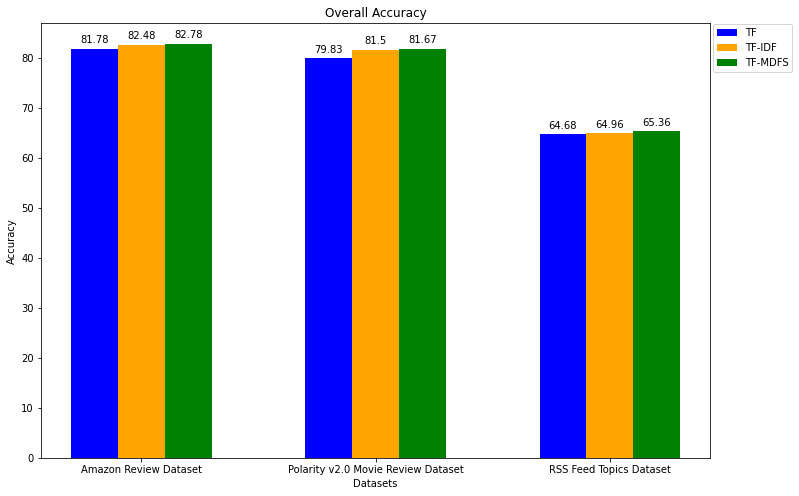

In [ ]:
draw_bar_graph(overall_accuracies, 'Overall Accuracy')

### Overall Accuracy for Bigrams

In [ ]:
print('Overall Accuracy:\n')

overall_bigram_accuracies = []
for name, dataset in datasets.items():
  row = [
    dataset['formal_name'],
    round(sum(bigram_tf_accuracies[name])/len(bigram_tf_accuracies[name]), 3),
    round(sum(bigram_tf_idf_accuracies[name])/len(bigram_tf_idf_accuracies[name]), 3),
    round(sum(bigram_tf_mdfs_accuracies[name])/len(bigram_tf_mdfs_accuracies[name]), 3)     
  ]
  row.append(round(sum(bigram_tf_mdfs_accuracies[name])/len(bigram_tf_mdfs_accuracies[name]) - sum(bigram_tf_accuracies[name])/len(bigram_tf_accuracies[name]), 3))

  overall_bigram_accuracies.append(row)

overall_bigram_accuracies = pd.DataFrame(
    overall_bigram_accuracies, 
    columns=['Dataset', 'TF Accuracy', 'TF-IDF Accuracy', 'TF-MDFS Accuracy', 'Improvement over TF']
)

with pd.option_context('display.max_colwidth', None):
  display(overall_bigram_accuracies)

Overall Accuracy:



,Dataset,TF Accuracy,TF-IDF Accuracy,TF-MDFS Accuracy,Improvement over TF
0,Amazon Review Dataset,83.500,84.600,84.933,1.433
1,Polarity v2.0 Movie Review Dataset,81.667,82.167,82.833,1.167
2,RSS Feed Topics Dataset,65.730,63.574,67.972,2.241


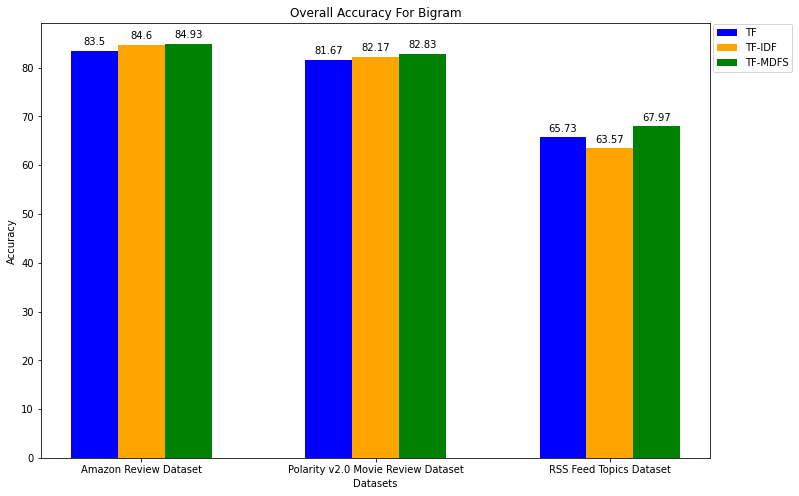

In [ ]:
draw_bar_graph(overall_bigram_accuracies, 'Overall Accuracy For Bigram')

  ### Accuracy for Naive Bayes

In [ ]:
print('Accuracy for Naive Bayes:\n')

naive_bayes_accuracies = []
for name, dataset in datasets.items():
  row = [
    dataset['formal_name'],
    round(tf_accuracies[name][0], 3),
    round(tf_idf_accuracies[name][0], 3),
    round(tf_mdfs_accuracies[name][0], 3)
  ]
  row.append(row[3] - row[1])

  naive_bayes_accuracies.append(row)

naive_bayes_accuracies = pd.DataFrame(
    naive_bayes_accuracies,
    columns=['Dataset', 'TF Accuracy', 'TF-IDF Accuracy', 'TF-MDFS Accuracy', 'Improvement over TF']
)

with pd.option_context('display.max_colwidth', None):
  display(naive_bayes_accuracies)

Accuracy for Naive Bayes:



,Dataset,TF Accuracy,TF-IDF Accuracy,TF-MDFS Accuracy,Improvement over TF
0,Amazon Review Dataset,80.500,81.450,81.600,1.100
1,Polarity v2.0 Movie Review Dataset,79.250,79.000,80.750,1.500
2,RSS Feed Topics Dataset,65.532,64.255,65.447,-0.085


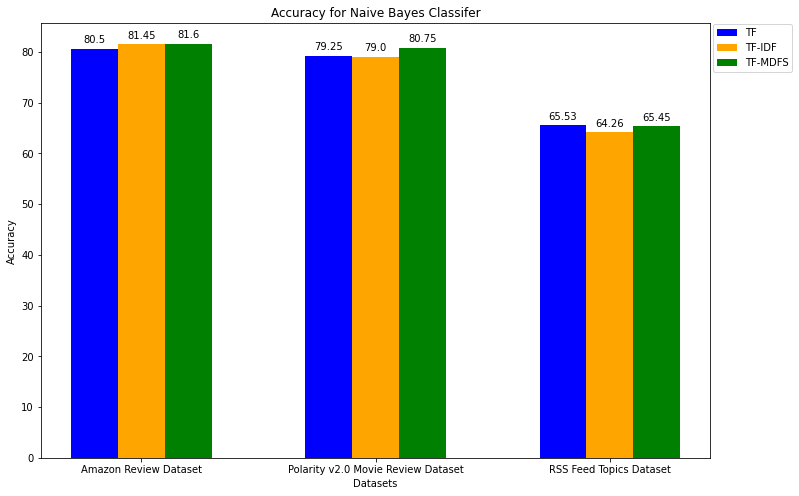

In [ ]:
draw_bar_graph(naive_bayes_accuracies, 'Accuracy for Naive Bayes Classifer')

### Accuracy for Support Vector Machine

In [ ]:
print('Accuracy for Support Vector Machine:\n')

svm_accuracies = []
for name, dataset in datasets.items():
  row = [
    dataset['formal_name'],
    round(tf_accuracies[name][1], 3),
    round(tf_idf_accuracies[name][1], 3),
    round(tf_mdfs_accuracies[name][1], 3)
  ]
  row.append(round(tf_mdfs_accuracies[name][1] - tf_accuracies[name][1], 3))
  svm_accuracies.append(row)


svm_accuracies = pd.DataFrame(
    svm_accuracies, 
    columns=['Dataset', 'TF Accuracy', 'TF-IDF Accuracy', 'TF-MDFS Accuracy', 'Improvement over TF']
)

with pd.option_context('display.max_colwidth', None):
  display(svm_accuracies)

Accuracy for Support Vector Machine:



,Dataset,TF Accuracy,TF-IDF Accuracy,TF-MDFS Accuracy,Improvement over TF
0,Amazon Review Dataset,82.200,83.350,83.500,1.300
1,Polarity v2.0 Movie Review Dataset,80.250,83.000,83.000,2.750
2,RSS Feed Topics Dataset,61.362,65.532,64.681,3.319


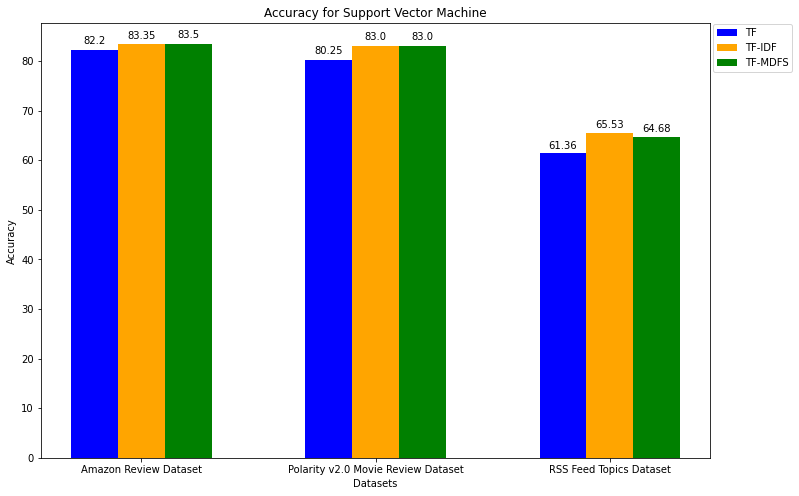

In [ ]:
draw_bar_graph(svm_accuracies, 'Accuracy for Support Vector Machine')

### Accuracy for Logistic Regression

In [ ]:
print('Accuracy for Logistic Regression:\n')

logistic_regression_accuracies = []
for name, dataset in datasets.items():
  row = [
    dataset['formal_name'],
    round(tf_accuracies[name][2], 3),
    round(tf_idf_accuracies[name][2], 3),
    round(tf_mdfs_accuracies[name][2], 3)
  ]
  row.append(round(tf_mdfs_accuracies[name][2] - tf_accuracies[name][2], 3))

  logistic_regression_accuracies.append(row)

logistic_regression_accuracies = pd.DataFrame(
    logistic_regression_accuracies,
    columns=['Dataset', 'TF Accuracy', 'TF-IDF Accuracy', 'TF-MDFS Accuracy', 'Improvement over TF']
)

with pd.option_context('display.max_colwidth', None):
  display(logistic_regression_accuracies)

Accuracy for Logistic Regression:



,Dataset,TF Accuracy,TF-IDF Accuracy,TF-MDFS Accuracy,Improvement over TF
0,Amazon Review Dataset,82.650,82.650,83.250,0.600
1,Polarity v2.0 Movie Review Dataset,80.000,82.500,81.250,1.250
2,RSS Feed Topics Dataset,67.149,65.106,65.957,-1.191


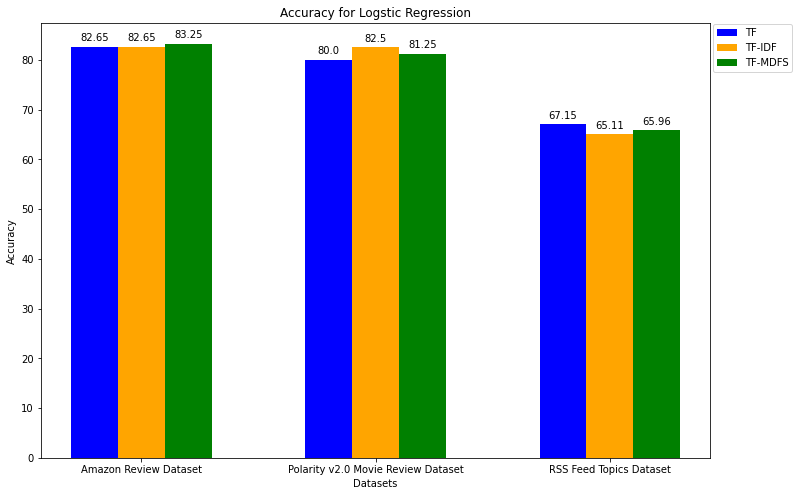

In [ ]:
draw_bar_graph(logistic_regression_accuracies, 'Accuracy for Logstic Regression')